# Auto MPG

https://archive.ics.uci.edu/ml/datasets/auto+mpg

## The Problem

Predict mpg (Miles per Gallon) based on 9 features.

## Getting the Data

In [1006]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

--2020-05-11 21:38:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30286 (30K) [application/x-httpd-php]
Saving to: ‘auto-mpg.data’

auto-mpg.data       100%[===================>]  29.58K   132KB/s    in 0.2s    

2020-05-11 21:38:02 (132 KB/s) - ‘auto-mpg.data’ saved [30286/30286]



In [1007]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

plt.style.use('ggplot')

In [1008]:
def read_df():
    columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 
               'weight', 'acceleration', 'model', 'origin', 'car']
    df = pd.read_csv('auto-mpg.data', 
                     delim_whitespace=True,
                     header=None,
                     names=columns,
                     na_values='?')
    
    return df
    
mpg_df = read_df()
mpg_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## EDA

In [835]:
mpg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car           398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [836]:
mpg_df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [837]:
mpg_eda_df = mpg_df.copy()
mpg_eda_df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model           0
origin          0
car             0
dtype: int64

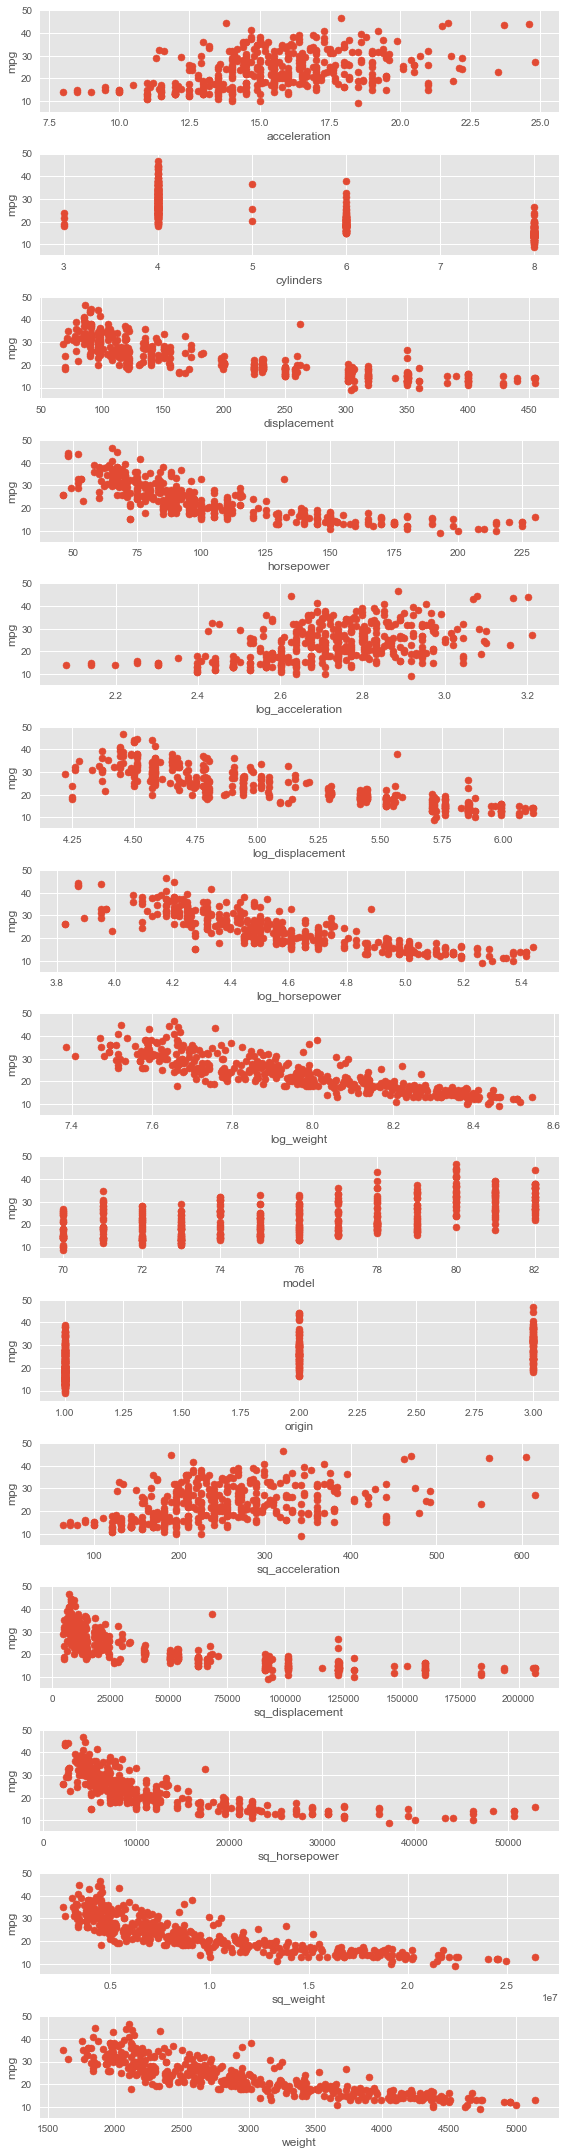

In [1001]:
cols = mpg_eda_df.columns.difference(['mpg', 'car'])

fig, ax = plt.subplots(len(cols), 1, figsize=(8, 30), sharey=True)

for i, col in enumerate(cols):
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('mpg')
    ax[i].scatter(mpg_eda_df[col], mpg_eda_df['mpg'])
    
plt.tight_layout()

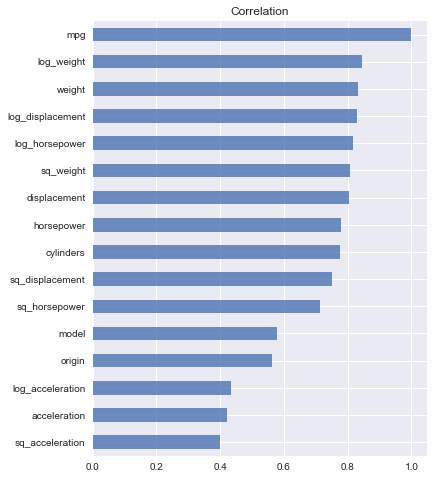

In [999]:
mpg_eda_df['log_displacement'] = np.log(mpg_eda_df.displacement)
mpg_eda_df['log_horsepower'] = np.log(mpg_eda_df.horsepower)
mpg_eda_df['log_acceleration'] = np.log(mpg_eda_df.acceleration)
mpg_eda_df['log_weight'] = np.log(mpg_eda_df.weight)

mpg_eda_df['sq_displacement'] = mpg_eda_df.displacement ** 2
mpg_eda_df['sq_horsepower'] = mpg_eda_df.horsepower ** 2
mpg_eda_df['sq_acceleration'] = mpg_eda_df.acceleration ** 2
mpg_eda_df['sq_weight'] = mpg_eda_df.weight ** 2

ax = (mpg_eda_df.corr().abs()['mpg']
        .sort_values(ascending=True)
        .plot(kind='barh', figsize=(6,8), alpha=0.8, title='Correlation'))

## Preprocessing & Feature Extraction

In [996]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    displacement_ix = 1
    horsepower_ix = 2
    weight_ix = 3
    acceleration_ix = 4
    
    def __init__(self, log_weight=False, log_accel=False, log_displacement=False, log_horsepower=False):
        self.log_weight = log_weight
        self.log_accel = log_accel
        self.log_displacement = log_displacement
        self.log_horsepower = log_horsepower
    
    def fit(self, X, y=None):
        return self
    
    def log_transform(self, X, ix):
        values = X[:, ix]
        X[:, ix] = np.log(values)
    
    def transform(self, X, y=None):
        if self.log_weight:
            self.log_transform(X, self.weight_ix)
        
        if self.log_horsepower:
            self.log_transform(X, self.horsepower_ix)
        
        if self.log_accel:
            self.log_transform(X, self.acceleration_ix)
        
        if self.log_displacement:
            self.log_transform(X, self.displacement_ix)
        
        return X

In [968]:
train_df, test_df = train_test_split(mpg_df, random_state=0, 
                                     test_size=0.2)

num_cols = ['acceleration', 'model', 'weight', 'horsepower', 'displacement']
cat_cols = ['origin']

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('feature_ext', FeatureExtractor()),
    ('std_scaler', StandardScaler()),
])

pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

X, y = train_df[num_cols + cat_cols], train_df['mpg']

## Training & Fine-tuning

In [972]:
model = RandomForestRegressor()

model_pipeline = Pipeline([
    ('data', pipeline),
    ('fit', model)
])

param_grid = [{
    'fit__max_features': [4, 5, 6, 7],
    'fit__n_estimators': [300, 320, 330, 340, 350],            
    'data__num__feature_ext__log_weight': [True, False],
    'data__num__feature_ext__log_accel': [True, False],
    'data__num__feature_ext__log_displacement': [True, False],
    'data__num__feature_ext__log_horsepower': [True, False]
}]

grid_search = GridSearchCV(model_pipeline, param_grid,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, cv=2, return_train_score=True)

grid_search = grid_search.fit(X, y)
scores = np.sqrt(-grid_search.best_score_)
print('Train error:', scores.mean(), '+/-', scores.std())

Train error: 2.8114012510507123 +/- 0.0


In [973]:
grid_search.best_params_

{'data__num__feature_ext__log_accel': True,
 'data__num__feature_ext__log_displacement': True,
 'data__num__feature_ext__log_horsepower': False,
 'data__num__feature_ext__log_weight': False,
 'fit__max_features': 6,
 'fit__n_estimators': 300}

In [975]:
model = grid_search.best_estimator_

X_t, y_t = test_df[num_cols + cat_cols], test_df['mpg']
error = np.sqrt(mean_squared_error(y_t, model.predict(X_t)))

print(f'Test set error: {error:.3f}')

Test set error: 2.604
